In [ ]:
!pip install tensorflow

In [ ]:
!pip install tf-keras-vis  # Install the tf-keras-vis library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.3 MB/s eta 0:00:00


Mounted at /content/drive
Images separated successfully into train and test folders.
Found 1133 files belonging to 3 classes.
Found 122 files belonging to 3 classes.
Augmented images saved to new folders.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 3285 files belonging to 3 classes.
Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 413s 3s/step - accuracy: 0.5908 - loss: 0.8821 - val_accuracy: 0.6393 - val_loss: 1.1286
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 72s 136ms/step - accuracy: 0.8457 - loss: 0.3995 - val_accuracy: 0.6721 - val_loss: 1.0550
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.9159 - loss: 0.2470 - val_accuracy: 0.6885 - val_loss: 1.0485
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 0.9478 - loss: 0.1447 - val_accuracy: 0.7213 - val_loss: 1.1650
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.9516 - loss: 0.1396 - val_accuracy: 0.7131 - val_loss: 1.3409
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/

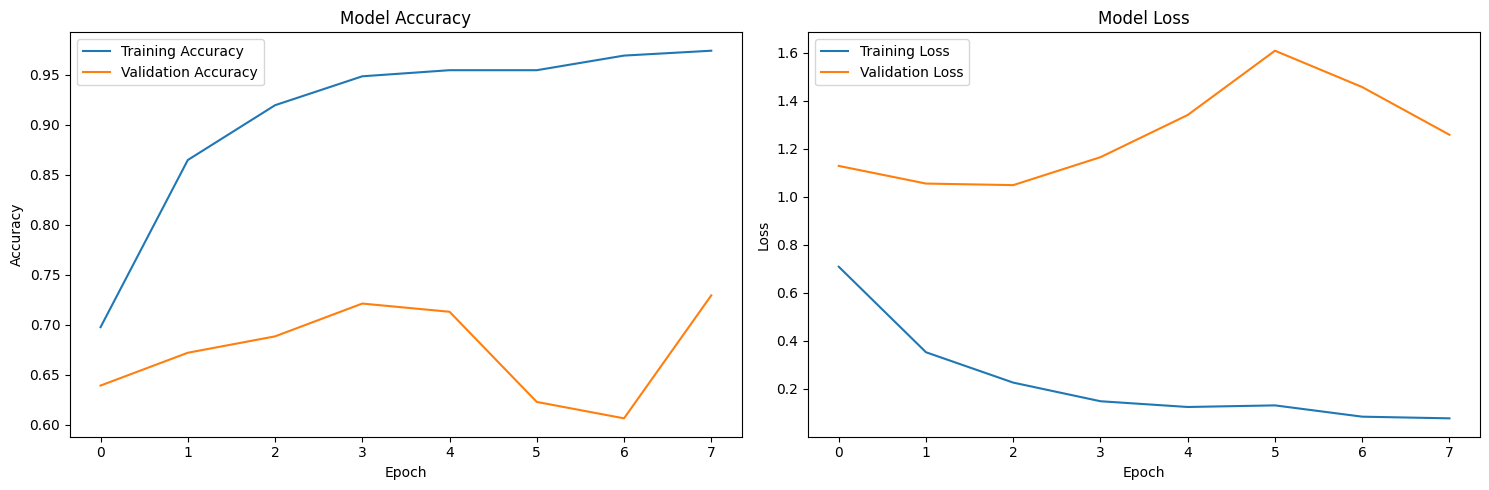

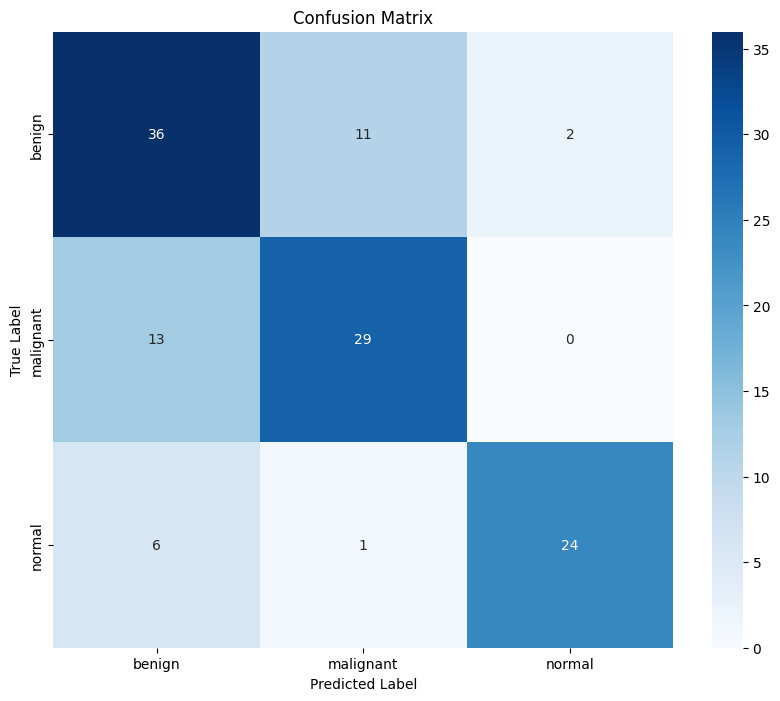

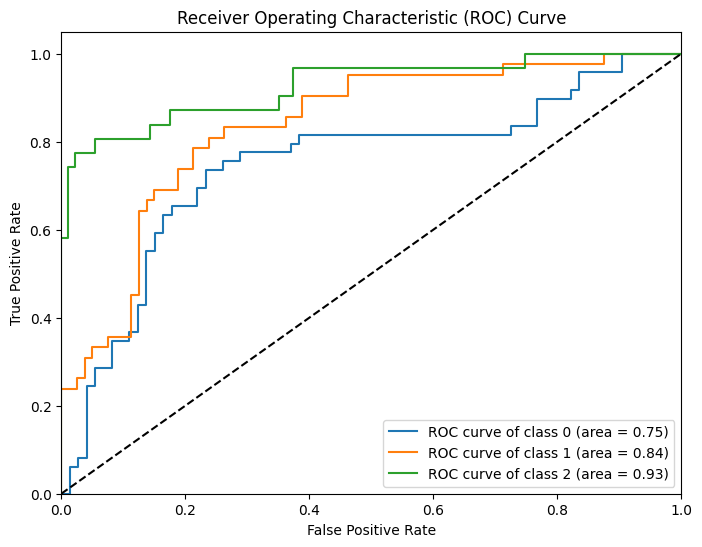

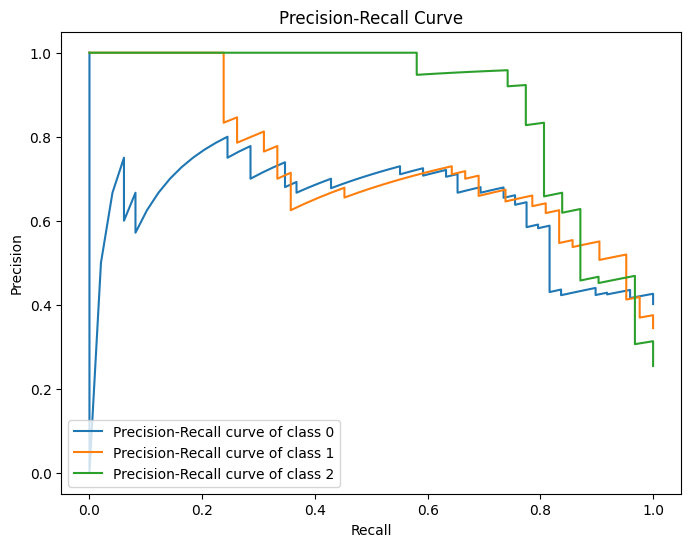

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


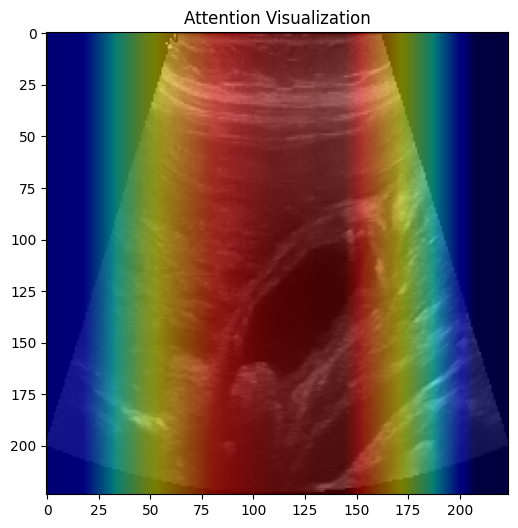

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
predicted_class_index: 
1
Last Conv2D layer: top_conv


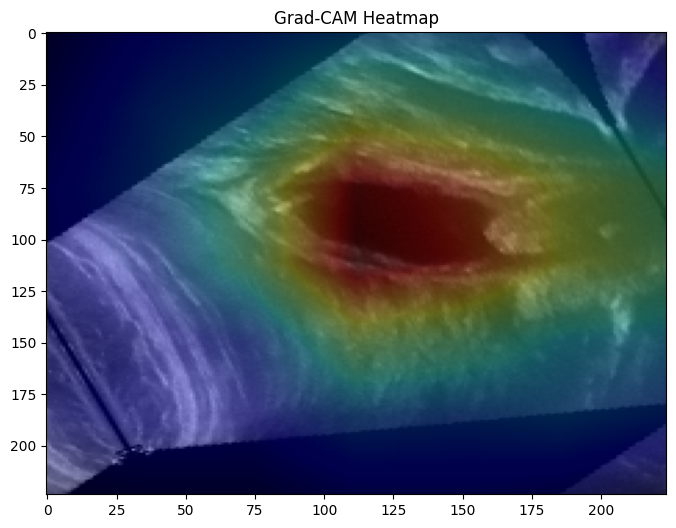

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Layer, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import os
import shutil
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tf_keras_vis.gradcam import Gradcam, GradcamPlusPlus
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.utils.scores import CategoricalScore

# Define the Gated Attention MIL Pooling layer
class GatedAttentionMILPooling(Layer):
    def __init__(self, **kwargs):
        super(GatedAttentionMILPooling, self).__init__(**kwargs)

    def build(self, input_shape):
        self.attention_gate = Dense(input_shape[-1], activation='sigmoid', name='attention_gate')
        self.feature_gate = Dense(input_shape[-1], activation='tanh', name='feature_gate')
        super(GatedAttentionMILPooling, self).build(input_shape)

    def call(self, x):
        attention_scores = self.attention_gate(x)
        gated_features = self.feature_gate(x)
        weighted_features = Multiply()([attention_scores, gated_features])
        weighted_features = tf.expand_dims(weighted_features, axis=1)
        pooled_features = tf.reduce_max(weighted_features, axis=2)

        return pooled_features

#1. Load and preprocess the GBCU dataset
from google.colab import drive
drive.mount('/content/drive')

# Define paths
data_folder = '/content/drive/MyDrive/GBCU/imgs/'  # Folder containing all images
train_file = '/content/drive/MyDrive/GBCU/train.txt'
test_file = '/content/drive/MyDrive/GBCU/test.txt'

# Output folders for training and testing
output_train_folder = '/content/drive/MyDrive/GBCU/dataset/train'
output_test_folder = '/content/drive/MyDrive/GBCU/dataset/test'

# Create folders for train and test data
for folder in [output_train_folder, output_test_folder]:
    os.makedirs(os.path.join(folder, 'normal'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'benign'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'malignant'), exist_ok=True)

# Function to separate images based on the label file
def separate_images(label_file, output_folder):
    with open(label_file, 'r') as f:
        for line in f:

            image_name, label = line.strip().split(',')
            label = int(label)

            # the label folder
            if label == 0:
                label_folder = 'normal'
            elif label == 1:
                label_folder = 'benign'
            elif label == 2:
                label_folder = 'malignant'
            else:
                continue

            # Source image path
            src_path = os.path.join(data_folder, image_name)

            # Destination path in label folder
            dest_path = os.path.join(output_folder, label_folder, image_name)

            # Copy the image to the new folder
            if os.path.exists(src_path):
                shutil.copy(src_path, dest_path)
            else:
                print(f"Image {image_name} not found in {data_folder}.")

# Separate images for train and test
separate_images(train_file, output_train_folder)
separate_images(test_file, output_test_folder)

print("Images separated successfully into train and test folders.")

# --- Preprocessing parameters ---
img_width, img_height = 224, 224  # Resize images
batch_size = 32

# --- Function to load and preprocess a single image ---
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((img_width, img_height))
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    return image

# --- Create TensorFlow datasets ---
train_dataset = tf.keras.utils.image_dataset_from_directory(
    output_train_folder,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_width, img_height),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    output_test_folder,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_width, img_height),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False
)

# --- Data augmentation ---
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

# --- Apply augmentation and save images ---
def augment_and_save(dataset, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    i = 0
    for images, labels in dataset:
        for j in range(images.shape[0]):
            image = images[j]
            label = labels[j]
            class_index = np.argmax(label.numpy())
            class_name = dataset.class_names[class_index]

            augmented_image = data_augmentation(tf.expand_dims(image, 0))  # Augment
            augmented_image = tf.squeeze(augmented_image)  # Remove batch dimension

            # Create the class subdirectory
            class_dir = os.path.join(output_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)

            # Save the augmented image
            output_filename = f"{class_name}_{i}_{j}.jpg"
            output_path = os.path.join(output_dir, class_name, output_filename)
            tf.keras.utils.save_img(output_path, augmented_image)
        i += 1

# --- output directories for augmented images ---
train_augmented_dir = '/content/drive/MyDrive/GBCU/dataset/train_augmented'
test_augmented_dir = '/content/drive/MyDrive/GBCU/dataset/test_augmented'

# --- Augment and save images ---
augment_and_save(train_dataset, train_augmented_dir)

print("Augmented images saved to new folders.")



# 2. Create the model
base_model = EfficientNetB0(weights='imagenet', include_top=False)

# Freeze initial layers of EfficientNet
for layer in base_model.layers[:100]:
    layer.trainable = False

x = base_model.output
x = GatedAttentionMILPooling(name='gated_attention_mil_pooling')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# 3. Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Load the augmented datasets ---
img_width, img_height = 224, 224  # Resize images
batch_size = 32

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_augmented_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_width, img_height),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True
)

# 4. Train the model
epochs = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)


# Function to plot training history
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
  ax1.plot(history.history['accuracy'], label='Training Accuracy')
  ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
  ax1.set_title('Model Accuracy')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy')
  ax1.legend()

  # Plot loss
  ax2.plot(history.history['loss'], label='Training Loss')
  ax2.plot(history.history['val_loss'], label='Validation Loss')
  ax2.set_title('Model Loss')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Loss')
  ax2.legend()

  plt.tight_layout()
  plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=classes, yticklabels=classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

# 5. Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# --- Predict on the test dataset ---
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Get true labels ---
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)

# --- Calculate metrics ---
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# --- Calculate AUC (requires one-hot encoded labels) ---
roc_auc_score_value = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')

# --- Print metrics ---
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {roc_auc_score_value:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# --- Plot training history ---
plot_training_history(history)

# --- Plot confusion matrix ---
plot_confusion_matrix(y_true, y_pred, classes=train_dataset.class_names)

# --- ROC Curve ---
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:,i])
  roc_auc[i] = auc(fpr[i], tpr[i])


# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
  plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# --- Precision-Recall Curve ---
precision = dict()
recall = dict()
for i in range(n_classes):
  precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:,i], y_pred_probs[:, i])

# Plot all Precision-Recall curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
  plt.plot(recall[i], precision[i], label=f'Precision-Recall curve of class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


# --- Attention Visualization ---
def visualize_attention(model, image):
  # 1. Create a sub-model to output the attention scores
  attention_model = Model(inputs=model.input, outputs=model.get_layer('gated_attention_mil_pooling').output)

  # 2. Get the attention scores for the input image
  attention_scores = attention_model.predict(np.expand_dims(image, axis=0))

  # 3. Resize attention scores to match the original image size
  attention_scores = tf.image.resize(attention_scores, (img_width, img_height))
  attention_scores = tf.reduce_mean(attention_scores, axis=-1)
  attention_scores = np.squeeze(attention_scores)

  # 4. Visualize the attention scores as a heatmap
  plt.figure(figsize=(8, 6))
  plt.imshow(image)
  plt.imshow(attention_scores, cmap='jet', alpha=0.5)  # Overlay heatmap
  plt.title('Attention Visualization')
  plt.show()

# sample image from the test dataset
for images, labels in test_dataset.take(1):
  sample_image = images[0]
  break

# Visualize attention for the sample image
visualize_attention(model, sample_image)

def visualize_gradcam(model, image, class_index):
  gradcam = Gradcam(model, clone=False)
  score = CategoricalScore(class_index)

  for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
      last_conv_layer = layer
      break

  print(f"Last Conv2D layer: {last_conv_layer.name}")
  cam = gradcam(score, image, penultimate_layer=last_conv_layer.name)

  if cam is None:
        print("CAM is None. Check the model and input image.")
        return
  heatmap = normalize(cam)

  heatmap_resized = tf.image.resize(heatmap, (image.shape[0], image.shape[1]))
  heatmap = np.squeeze(heatmap)

  plt.figure(figsize=(8, 6))
  plt.imshow(image)
  plt.imshow(heatmap, cmap='jet', alpha=0.3, aspect='auto')
  plt.title('Grad-CAM Heatmap')
  plt.show()

def preprocess_sample_image(image):
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    image = data_augmentation(tf.expand_dims(image, 0))
    image = tf.squeeze(image)
    return image

# Get a sample image and its true label from the test dataset
for images, labels in test_dataset.take(1):
    sample_image = images[0]
    sample_label = labels[0]
    break

test_image = preprocess_sample_image(sample_image)

# Get the predicted class index
y_pred_probs = model.predict(np.expand_dims(test_image, axis=0))
predicted_class_index = np.argmax(y_pred_probs)
print("predicted_class_index: ")
print(predicted_class_index)

# Visualize Grad-CAM
visualize_gradcam(model, test_image, predicted_class_index)

model.save('/content/drive/MyDrive/GBCU/with_grad_cam_trained_model.keras')  #save the model